In [13]:
import potential_data
import potential_analyze
import pandas as pd
import fit
import sys
import os
import warnings
import matplotlib.pyplot as plt
from scipy.optimize import OptimizeWarning

sys.path.append(os.path.join(os.path.dirname(
    os.path.abspath(''))))
import common.plots as plots
import functional
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter("ignore", OptimizeWarning)

In [14]:
def potential_smearing_custom(paths, df_smearing_path):
    df = potential_data.get_potantial_df(paths, ['smearing_step', 'range_min_T', 'range_min_r', 'copy'])
    df_smearing = pd.read_csv(df_smearing_path)
    df = potential_analyze.slice_smearing(df, df_smearing)
    df = df.groupby(df.index.names + ['r/a']).apply(fit.potential_fit_T_range).reset_index(level=['r/a']).reset_index(level=-1, drop=True)
    df_fit = df.groupby(df.index.names).apply(fit.make_fit_range, fit.func_cornell, ['V0', 'alpha', 'sigma'], 'r/a', 'aV(r)', err_col='err').reset_index(level=-1, drop=True)
    df_fit = df_fit.groupby(df.index.names).apply(fit.average_fit_p_value, ['V0', 'alpha', 'sigma'], 'r/a').reset_index(level=-1, drop=True)
    df_curves = df_fit.groupby(df_fit.index.names).apply(fit.make_fit_curve, fit.func_cornell, 'r/a', 'aV(r)', ['V0', 'alpha', 'sigma']).reset_index(level=-1, drop=True).reset_index(level=['smearing_step'])
    df = df.reset_index(level=['smearing_step'])
    return df, df_fit, df_curves

In [24]:
def potential_copy_dependnce(lattice_size, L, beta, smearing, additional_params, decomposition_type, paths_functional):
    paths = [{'path': f'../../result/smearing/potential/wilson_loop/fundamental/on-axis/su3/gluodynamics/{lattice_size}/beta{beta}/{smearing}/{additional_params}/potential_{decomposition_type}.csv',
          'parameters': {'beta': beta, 'range_min_T': L // 2 - 4, 'range_min_r': L // 2 - 3}, 'constraints': {'r/a': (1, L // 2), 'T': (1, L // 2 - 1)}}]
    df_smearing_path = f'../../result/smearing/potential/su3/gluodynamics/APE_parameters/{lattice_size}/beta{beta}/{smearing}/{additional_params}/APE_parameters_{decomposition_type}.csv'
    df, df_fit, df_curves = potential_smearing_custom(paths, df_smearing_path)
    df = df.reset_index(level=['copy'])
    df_fit = df_fit.reset_index(level=['copy'])
    df_curves = df_curves.reset_index(level=['copy'])
    image_path = f'../../images/smearing/potential/su3/gluodynamics/potential_copy_dependence/{lattice_size}/beta{beta}/{smearing}/{additional_params}'
    image_name = f'potential_{decomposition_type}'
    fg = plots.make_plot(df, 'r/a', 'aV(r)', 'copy', 'r/a', 'aV(r)', f'{decomposition_type} potential', image_path, image_name, True, err='err', df_fits=df_curves)
    plots.save_image(image_path, image_name, fg)
    plt.close()
    image_path_string = f'../../images/smearing/potential/su3/gluodynamics/string_tension_copy_dependence/{lattice_size}/beta{beta}/{smearing}/{additional_params}'
    image_name_string = f'string_tension_{decomposition_type}'
    plots.make_plot(df_fit, 'copy', 'sigma', None, r'$n_{copy}$', r'$\sigma$', '', f'../../images/potential/su3/gluodynamics/', 'string_tension', True, err='sigma_err')
    plots.save_image(image_path_string, image_name_string, fg)
    plt.close()
    df_fit['copy_inv'] = 1/df_fit['copy']
    image_name_string = f'string_tension_{decomposition_type}_inv_copy'
    fg = plots.make_plot(df_fit, 'copy_inv', 'sigma', None, r'$1/n_{copy}$', r'$\sigma$', '', f'../../images/potential/su3/gluodynamics/', 'string_tension', True, err='sigma_err')
    plots.save_image(image_path_string, image_name_string, fg)
    plt.close()
    df_func = functional.read_functional(paths_functional)
    df_func = functional.fill_funcational_max(df_func, ['size'])
    df_fit = df_fit.merge(df_func, how='inner', on=['copy'])
    df_fit['functional'] = (1 - df_fit['functional']) * 3/2
    df_fit = df_fit[df_fit['copy'] < 20]
    image_name_string = f'string_tension_{decomposition_type}_functional'
    fg = plots.make_plot(df_fit, 'functional', 'sigma', None, r'$F_{lat}$', r'$\sigma$', '', f'../../images/potential/su3/gluodynamics/', 'string_tension', True, err='sigma_err')
    plots.save_image(image_path_string, image_name_string, fg)
    plt.close()

In [25]:
paths_functional = [{'path': f'../../data/mag/functional/su3/gluodynamics/16^4/beta6.0/steps_0/copies=20/functional', 'parameters': {'size': '16^4'}, 'conf_range': (1, 5000), 'padding': 5}]
potential_copy_dependnce('16^4', 16, '6.0', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole', paths_functional)

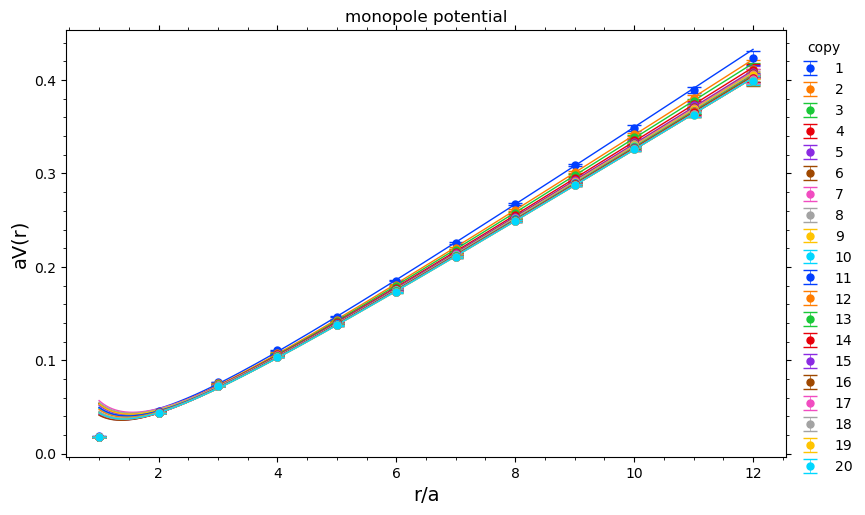

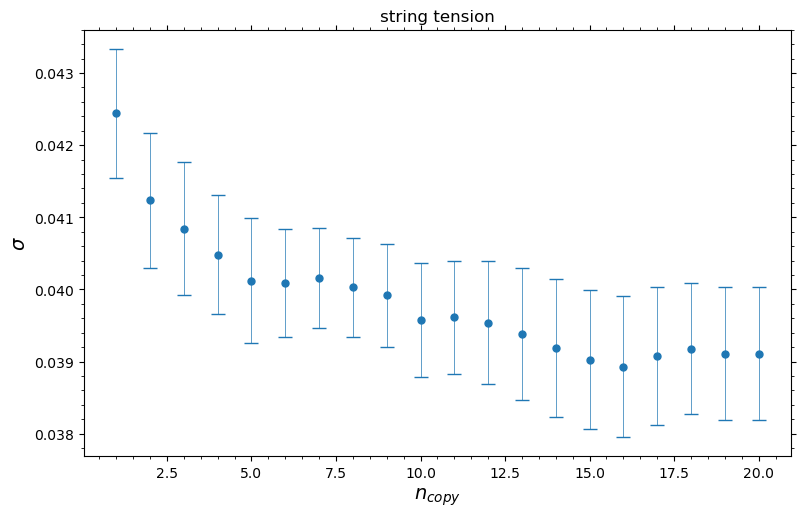

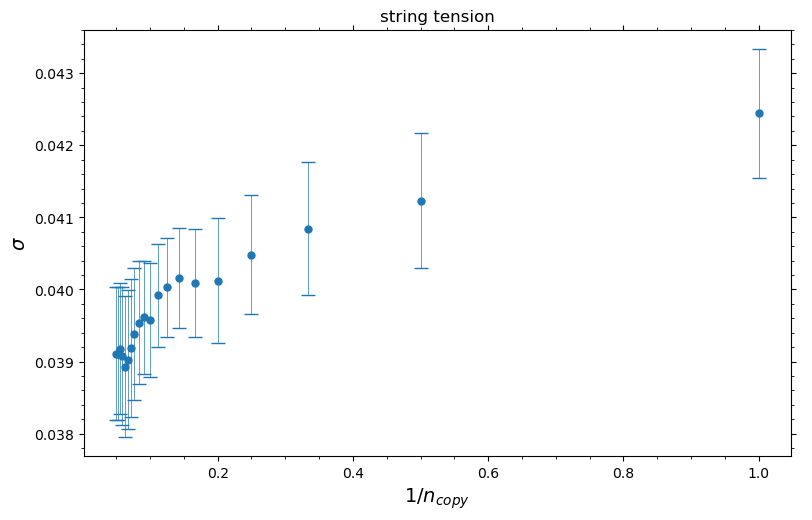

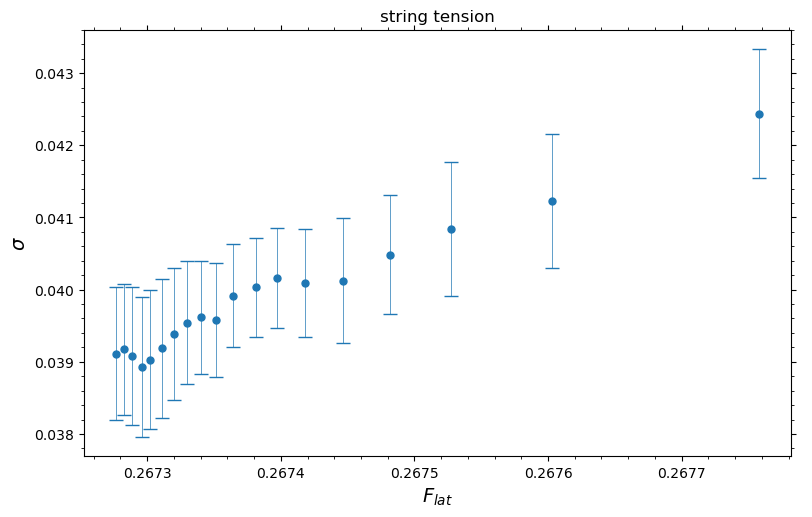

In [ ]:
paths_functional = [{'path': f'../../data/mag/functional/su3/gluodynamics/24^4/beta6.0/steps_0/copies=20/functional', 'parameters': {'size': '24^4'}, 'conf_range': (1, 5000)}]
potential_copy_dependnce('24^4', 24, '6.0', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole', paths_functional)

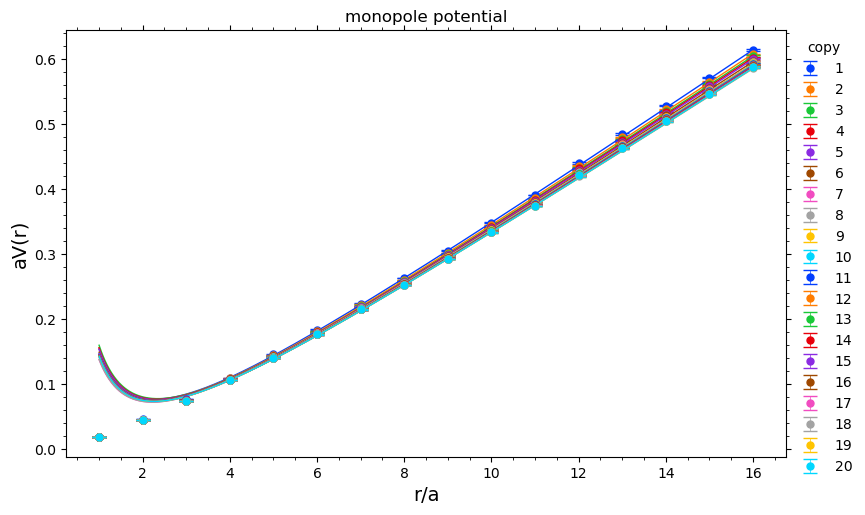

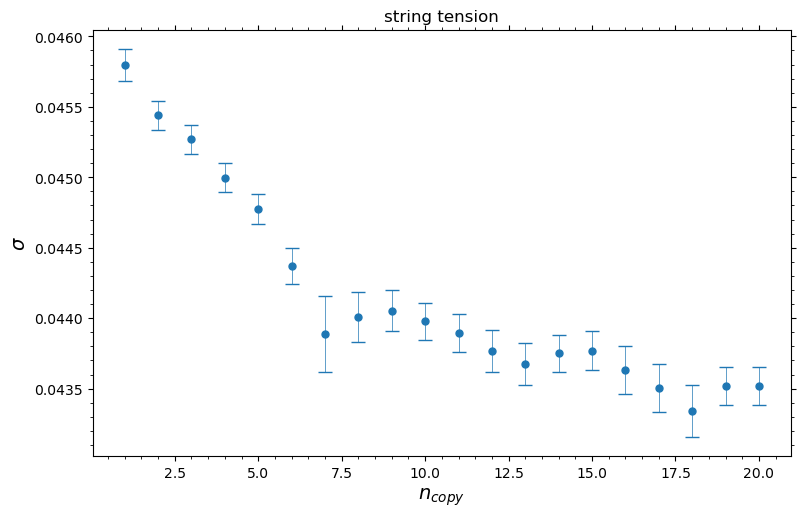

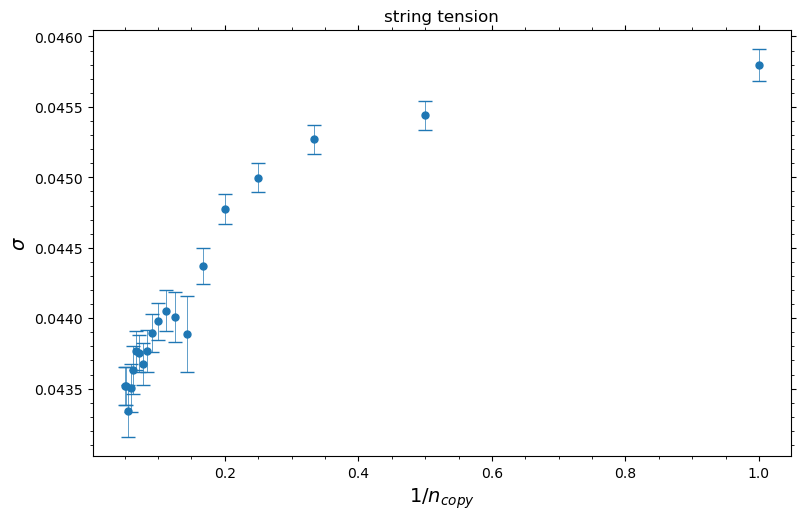

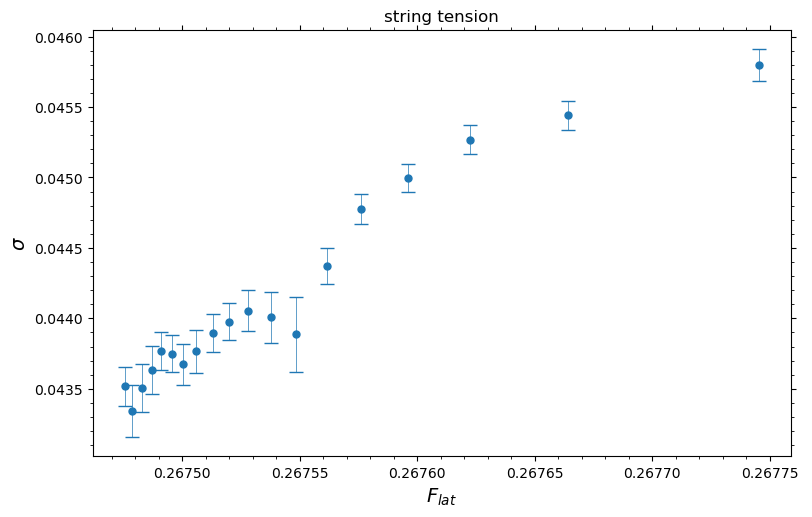

In [ ]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s1/functional', 'conf_range': (1, 5000), 'parameters': {'size': '32^4'}, 'chain': 1},
                    {'path': '../../data/mag/functional/su3/gluodynamics/32^4/beta6.0/steps_0/copies=20/s2/functional', 'conf_range': (1, 5000), 'parameters': {'size': '32^4'}, 'chain': 2}]
potential_copy_dependnce('32^4', 32, '6.0', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole', paths_functional)

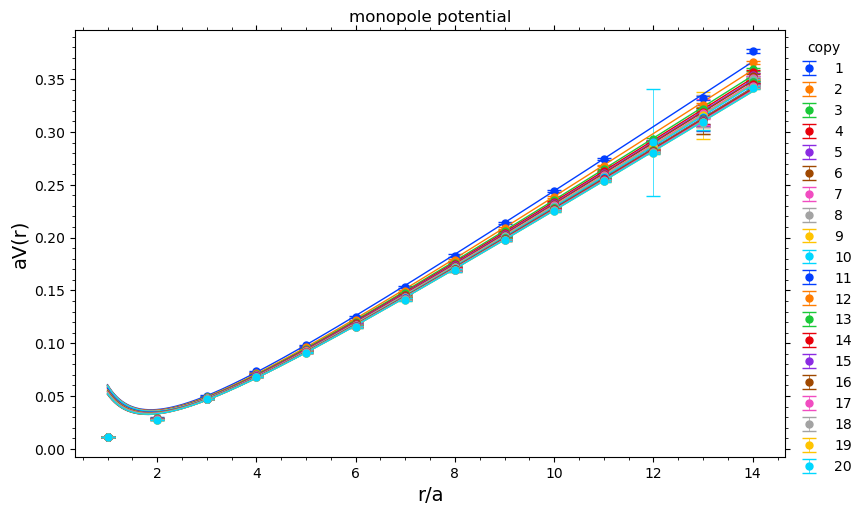

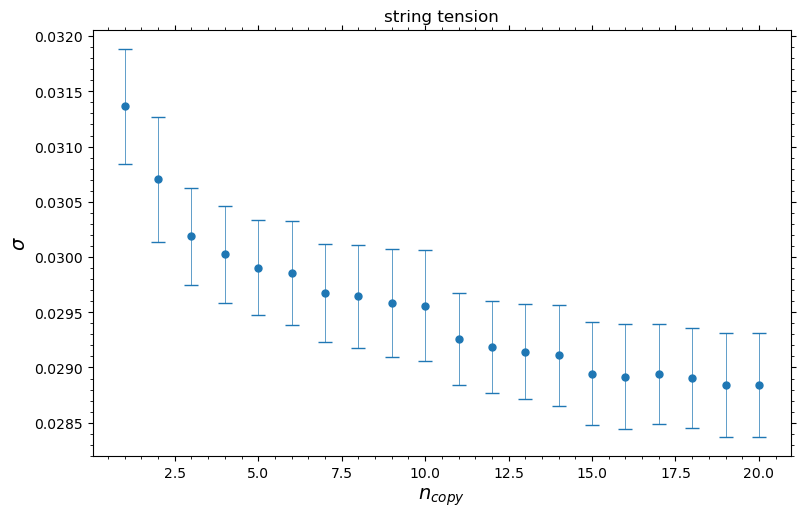

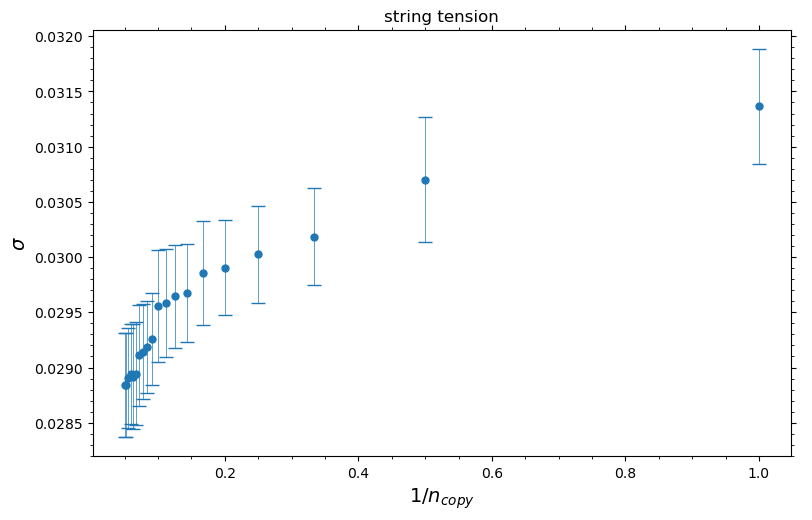

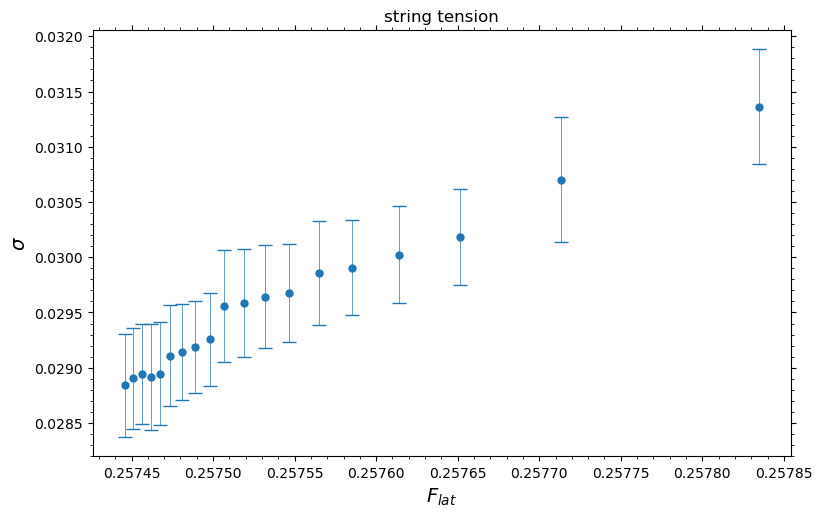

In [ ]:
paths_functional = [{'path': f'../../data/mag/functional/su3/gluodynamics/28^4/beta6.1/steps_0/copies=20/functional', 'parameters': {'size': '28^4'}, 'conf_range': (1, 5000)}]
potential_copy_dependnce('28^4', 28, '6.1', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole', paths_functional)

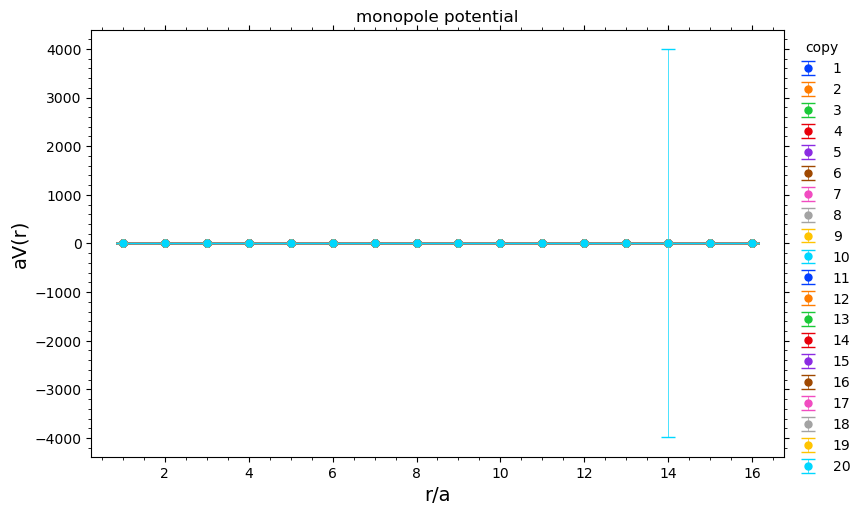

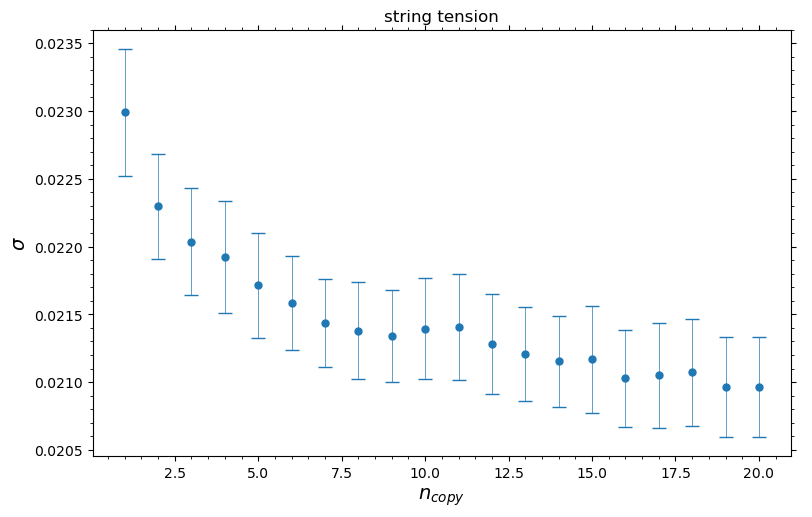

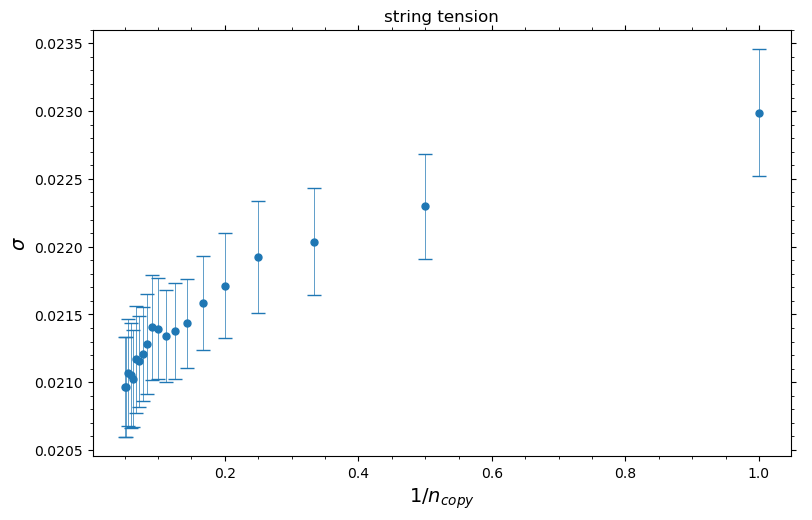

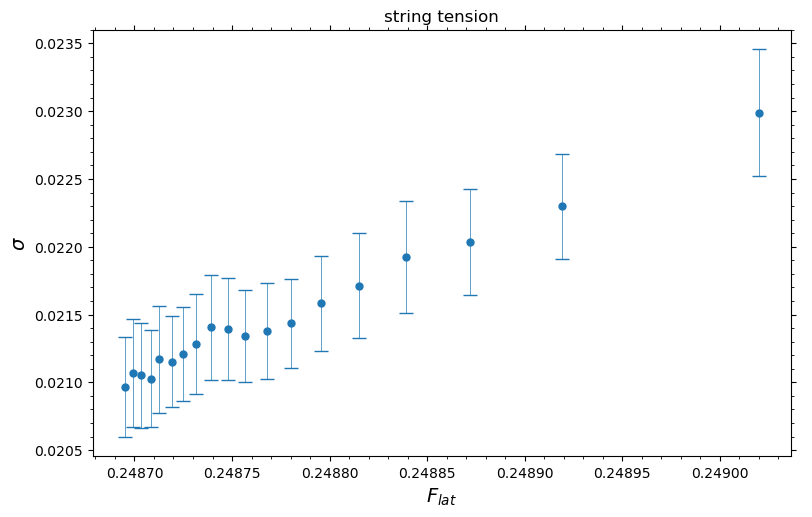

In [ ]:
paths_functional = [{'path': f'../../data/mag/functional/su3/gluodynamics/32^4/beta6.2/steps_0/copies=20/functional', 'parameters': {'size': '32^4'}, 'conf_range': (1, 5000)}]
potential_copy_dependnce('32^4', 32, '6.2', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole', paths_functional)

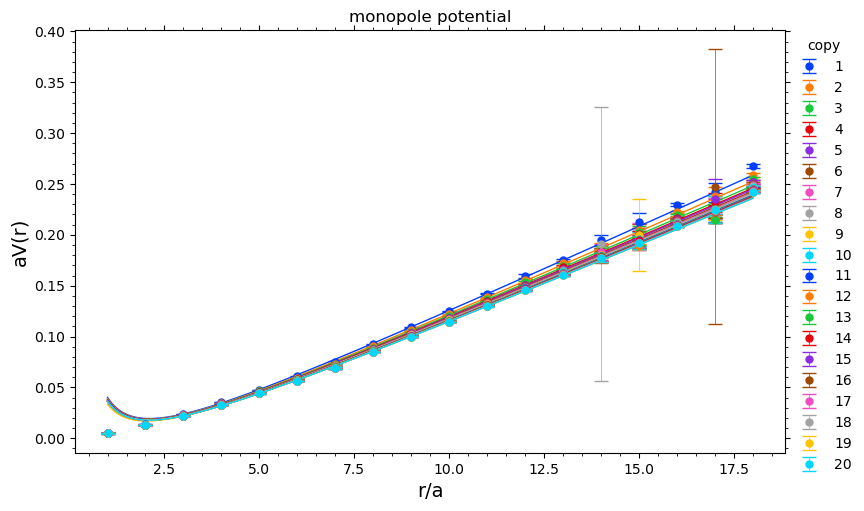

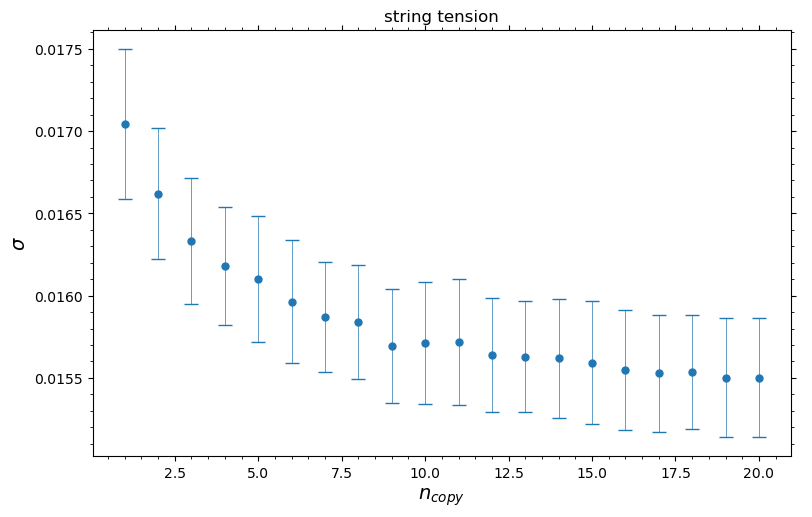

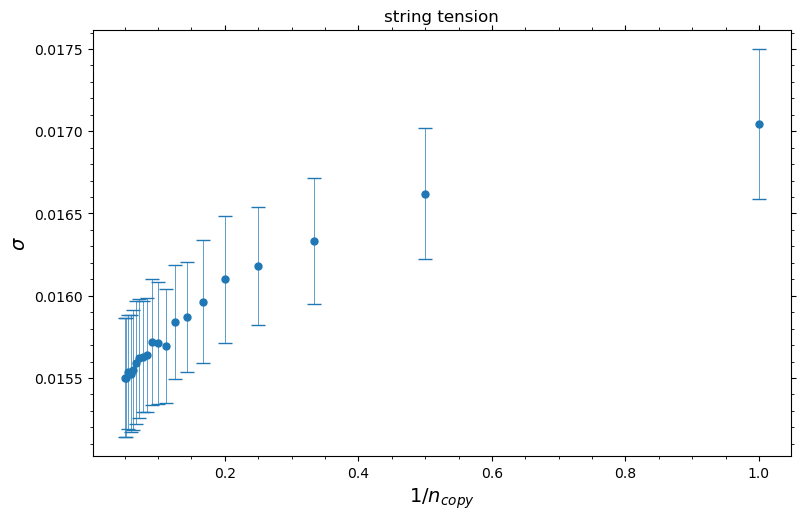

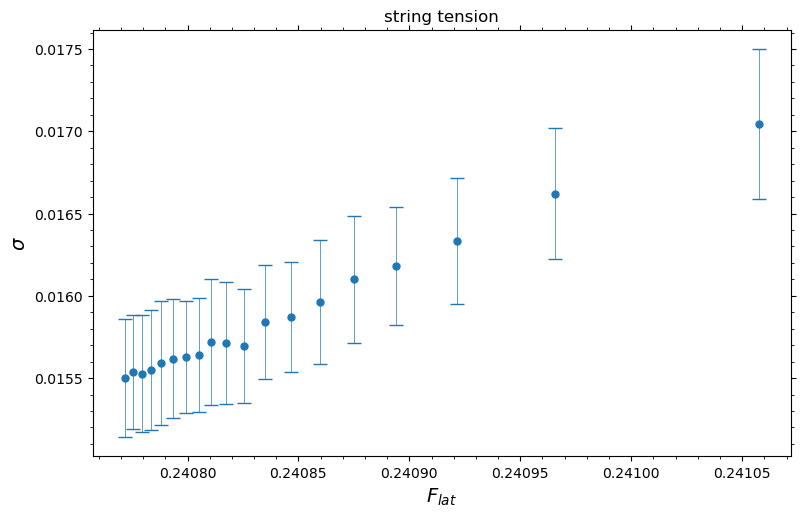

In [ ]:
paths_functional = [{'path': f'../../data/mag/functional/su3/gluodynamics/36^4/beta6.3/steps_0/copies=20/functional', 'parameters': {'size': '36^4'}, 'conf_range': (1, 5000)}]
potential_copy_dependnce('36^4', 36, '6.3', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole', paths_functional)

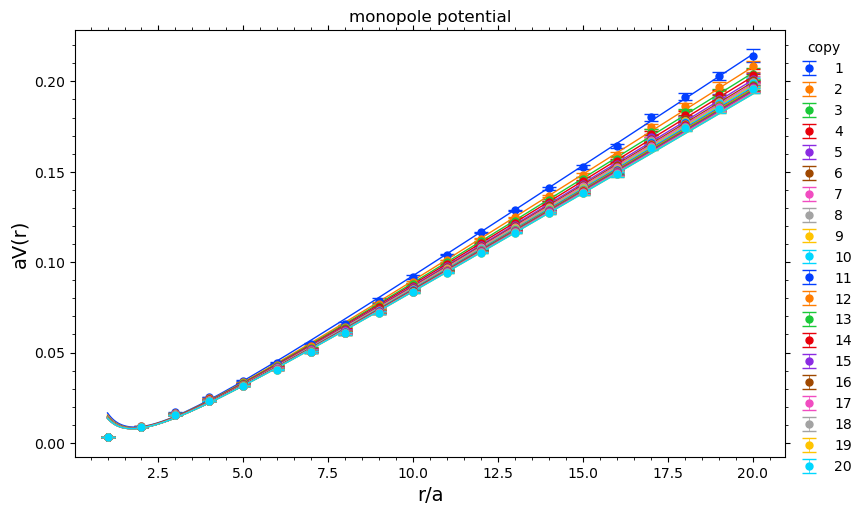

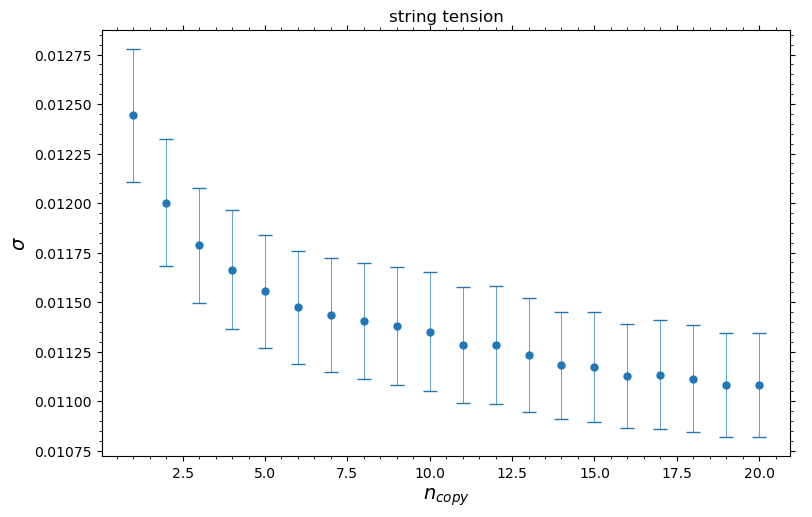

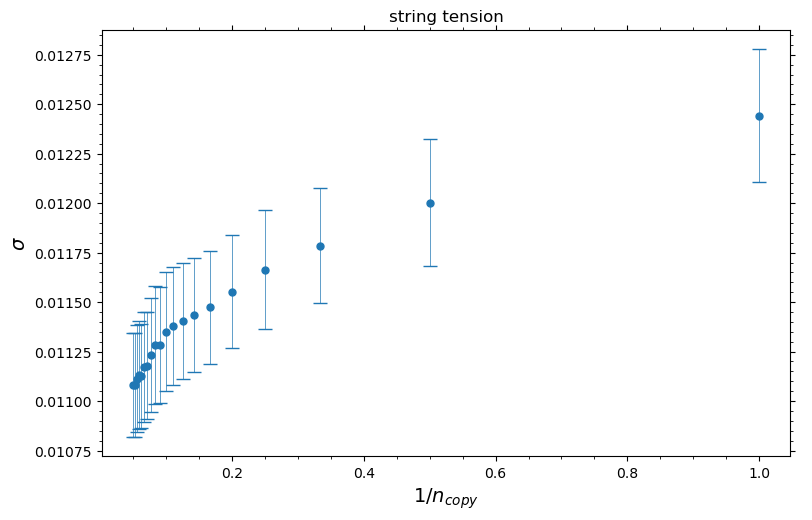

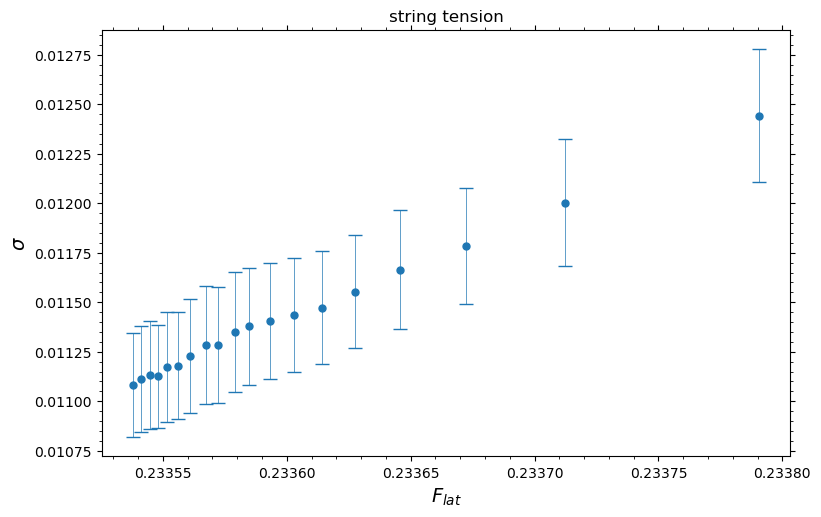

In [ ]:
paths_functional = [{'path': '../../data/mag/functional/su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s1/functional', 'conf_range': (1, 5000), 'parameters': {'size': '40^4'}, 'chain': 1},
                    {'path': '../../data/mag/functional/su3/gluodynamics/40^4/beta6.4/steps_0/copies=20/s2/functional', 'conf_range': (1, 5000), 'parameters': {'size': '40^4'}, 'chain': 2}]
potential_copy_dependnce('40^4', 40, '6.4', 'HYP0_alpha=1_1_0.5_APE_alpha=0.6', 'steps_0/copies=20', 'monopole', paths_functional)